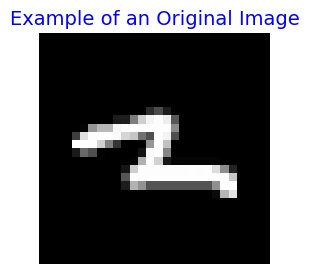

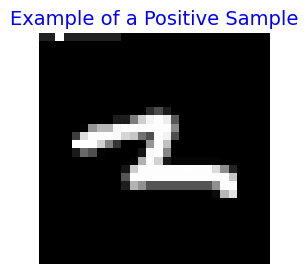

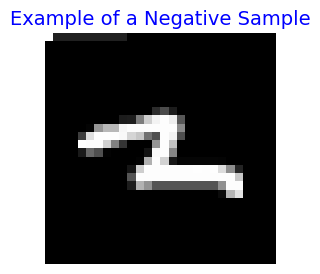

Code is training the Layer: 100%|██████████| 2/2 [01:10<00:00, 35.01s/it]


Train accuracy: 90.96499681472778 %
Train error: 0.09035003185272217
Test accuracy: 90.562504529953 %
Test error: 0.09437495470046997


In [24]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader


class Layer(nn.Linear):
    """
    Custom neural network layer class that extends the functionality of the nn.Linear class.

    This class introduces additional features such as ReLU activation, input normalization, and an Adam optimizer for training.

    Parameters:
    - in_features: Number of input features.
    - out_features: Number of output features.
    - bias: Whether to include bias in the linear transformation.
    - device: Device on which the layer will be instantiated.
    - dtype: Data type of the layer's parameters.

    Attributes:
    - relu: ReLU activation function.
    - opt: Adam optimizer with a default learning rate of 0.025.
    - threshold: Threshold for activation.
    - num_epochs: Number of training epochs.

    Methods:
    - forward: Forward pass through the layer.
    - normalize_input: Normalize the input vector.
    - transform_input: Transform the normalized input.
    - apply_activation: Apply ReLU activation.
    - calculateLoss: Calculate the loss using hinge loss with a threshold.
    - train: Training loop using tqdm for progress visualization.
    """
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        # Call the constructor of the parent class (nn.Linear)
        super().__init__(in_features, out_features, bias, device, dtype)
        # Define a ReLU activation function
        self.relu = torch.nn.ReLU()
        # Initialize an Adam optimizer with a learning rate of 0.03
        self.opt = Adam(self.parameters(), lr=0.025)
        # Set a threshold for activation
        self.threshold = 1.6
        # Set the number of training epochs
        self.num_epochs = 800

    def forward(self, input_vector):
        # Normalize the input vector
        normalized_input = self.normalize_input(input_vector)
        # Transform the normalized input
        transformed_input = self.transform_input(normalized_input)
        # Apply ReLU activation
        return self.apply_activation(transformed_input)

    def normalize_input(self, input_vector):
        # Normalize the input vector along the second dimension using regularization
        normalized_direction = input_vector / (input_vector.norm(2, 1, keepdim=True) + 1e-4)
        return normalized_direction

    def transform_input(self, normalized_input):
        # Weighted sum of the normalized input using the transposed weight matrix
        weighted_input = torch.mm(normalized_input, self.weight.T)
        # Add bias to the weighted input
        biased_input = weighted_input + self.bias.unsqueeze(0)
        return biased_input

    def apply_activation(self, transformed_input):
        # Apply ReLU activation function
        return self.relu(transformed_input)

    def calculateLoss(self, x_pos, x_neg):
        # Calculate the loss using hinge loss with a threshold
        loss = torch.log(1 + torch.exp(torch.cat([-self.forward(x_pos).pow(2).mean(1) + self.threshold, self.forward(x_neg).pow(2).mean(1) - self.threshold]))).mean()

        # Zero the gradients
        self.opt.zero_grad()

        # Backpropagation
        loss.backward()

        # Update the model parameters
        self.opt.step()

    def train(self, x_pos, x_neg):
        # Training loop using tqdm for progress visualization
        for i in tqdm(range(self.num_epochs)):
            self.calculateLoss(x_pos, x_neg)  # Call calculateLoss using self reference

        # Return the forward pass results for positive and negative samples after training
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()
class Net(torch.nn.Module):
    """
    Custom neural network class representing a sequence of layers.

    Methods:
    - __init__: Constructor initializing the network with an empty list for layers.
    - predict: Make predictions using the given input for each label.
    - train: Train the network using positive and negative samples.

    Attributes:
    - layers: List to store the layers of the neural network.
    """

    def __init__(self):
        super().__init__()
        self.layers = []  # List to store the layers of the neural network

    def predict(self, x):
        """
        Make predictions for each label based on the goodness values of the layers.

        Parameters:
        - x: Input data for making predictions.

        Returns:
        - Tensor: Predicted labels for the input data.
        """
        probability = []  # List to store goodness values for each label
        for label in range(10):
            h = x.clone()
            h[:, :10] = 0.0
            h[range(x.shape[0]), label] = x.max()
            Good = []  # List to store goodness values for each layer
            for layer in self.layers:
                h = layer(h)
                Good.append((h ** 2).mean(dim=1))  # Calculating goodness values for the layer
            probability.append(torch.sum(torch.stack(Good), dim=0).unsqueeze(1))  # Summing up goodness values for all layers
        return torch.cat(probability, 1).argmax(1)  # Returning the label with the maximum goodness value

    def train(self, x_pos, x_neg, dims):
        """
        Train the network using positive and negative samples.

        Parameters:
        - x_pos: Positive samples for training.
        - x_neg: Negative samples for training.
        - dims: List of dimensions for creating the layers.

        Returns:
        - Tuple: Updated positive and negative samples after training.
        """
        self.layers = [Layer(dims[d], dims[d + 1]).cuda() for d in range(len(dims) - 1)]

        positive, negative = x_pos, x_neg

        for i, layer in tqdm(enumerate(self.layers), desc="Code is training the Layer", total=len(self.layers)):
            positive, negative = layer.train(positive, negative)



# Define a series of data transformations to be applied to the MNIST dataset
transform = Compose([
    # Convert the image data to PyTorch tensors
    ToTensor(),
    # Normalize the image data with mean and standard deviation values specific to MNIST
    Normalize((0.1307,), (0.3081,)),
    # Reshape the tensor to a one-dimensional vector
    Lambda(lambda x: x.view(-1))
])

# Create a DataLoader for the training set
train_loader = DataLoader(
    # Load the MNIST training dataset with the specified transformations
    MNIST('./data/', train=True, download=True, transform=transform),
    # Set batch size to load the entire training set in one batch
    batch_size=40000,
    # Shuffle the training data at the beginning of each epoch
    shuffle=True
)

# Create a DataLoader for the test set
test_loader = DataLoader(
    # Load the MNIST test dataset with the same transformations as the training set
    MNIST('./data/', train=False, download=True, transform=transform),
    # Set batch size to load the entire test set in one batch
    batch_size=8000,
    # Do not shuffle the test data during evaluation
    shuffle=False
)
# Set the random seed for reproducibility
torch.manual_seed(1234)

# Instantiate the neural network
net = Net()

# Load a batch of training data and move it to the GPU
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()

# Create positive and negative samples for training
x_pos = x.clone()
x_pos[:, :10] = 0.0
x_pos[range(x.shape[0]), y] = x.max()
x_neg = x.clone()
x_neg[:, :10] = 0.0
x_neg[range(x.shape[0]), y[torch.randperm(x.size(0))]] = x.max()

# Function to display an image with a title
def show_image_with_title(image, title):
    plt.figure(figsize=(3, 3))  # Set the figure size
    plt.imshow(image, cmap="gray")  # Display the image in grayscale
    plt.title(title, fontsize=14, color='blue')  # Set the title appearance
    plt.axis('off')  # Turn off axis
    plt.show()

# Display an example of the original image
reshaped = x[5].cpu().reshape(28, 28)
show_image_with_title(reshaped, 'Example of an Original Image')

# Display an example of a positive sample
reshaped = x_pos[5].cpu().reshape(28, 28)
show_image_with_title(reshaped, 'Example of a Positive Sample')

# Display an example of a negative sample
reshaped = x_neg[5].cpu().reshape(28, 28)
show_image_with_title(reshaped, 'Example of a Negative Sample')

# Train the neural network with the positive and negative samples
net.train(x_pos, x_neg, [784, 500, 500])

# Evaluate on the training set
train_predictions = net.predict(x)
train_accuracy = (train_predictions.eq(y).float().mean().item()) * 100
train_error = 1.0 - train_accuracy / 100
print('Train accuracy:', train_accuracy, '%')
print('Train error:', train_error)

# Evaluate on the test set
test_data, test_labels = next(iter(test_loader))
test_data, test_labels = test_data.cuda(), test_labels.cuda()

test_predictions = net.predict(test_data)
test_accuracy = (test_predictions.eq(test_labels).float().mean().item()) * 100
test_error = 1.0 - test_accuracy / 100
print('Test accuracy:', test_accuracy, '%')
print('Test error:', test_error)

